# Sequence models

Resources:
1. One-to-many, many-to-one and other variants on [StackOVerflow](https://stackoverflow.com/questions/43034960/many-to-one-and-many-to-many-lstm-examples-in-keras).

#### Imports and user variables

In [1]:
%run -i imports_and_user_variables.py 1000
from __future__ import print_function # Strange bug, this function can't be imported

Using TensorFlow backend.


Imports and variable definitions successful, using 1000 files.


In [4]:
import os, shutil
import random
import sys
import numpy as np
import pypianoroll
from matplotlib import pyplot as plt
import cPickle as pickle
import pianoroll_utils
import IPython
import h5py

from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, BatchNormalization, MaxPooling2D, UpSampling2D
from keras.models import Model, Sequential
from keras.callbacks import TensorBoard
from keras.models import load_model
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers import Activation, LSTM, RNN, Concatenate, concatenate, Dropout
from keras import optimizers

from __future__ import print_function
from keras.models import Sequential
from keras import layers
from six.moves import range

NUM_FILES = 1000
SEQ_FILE = './pickle_jar/seq_{}_songs_clipped96.h5'.format(NUM_FILES)
WINDOW_LENGTH = 4

PICKLE_FILE = './pickle_jar/norm_units_50_songs.pkl'
SEQ_PICKLE_FILE = './pickle_jar/seq_units_200_songs_clipped96.pkl'
SEQ_EMBED_PICKLE_FILE = './pickle_jar/seq_embed_units_200_songs_clipped96_vaev5.pkl'

# Music shape
MIN_PITCH = 13 # C-1
MAX_PITCH = 108 # C7 (MIDI 108)
BEATS_PER_UNIT = 4
NUM_TRANSPOSITIONS = 3 # Number of transpositions to perform (maximum 12)

# Don't change unless you know what you're doing
BEAT_RESOLUTION = 24 # This is set by the encoding of the lpd-5 dataset, corresponds to number of ticks per beat
PARTITION_NOTE = 60 # Break into left- and right-accompaniments at middle C
NUM_PITCHES = MAX_PITCH - MIN_PITCH + 1
NUM_TICKS = BEATS_PER_UNIT * BEAT_RESOLUTION

In [2]:
from keras.utils import Sequence

class TimeseriesGeneratorTwoInputs(Sequence):
    """Keras data reading class
    Utility class for generating batches of temporal data.
    This class takes in a sequence of data-points gathered at
    equal intervals, along with time series parameters such as
    stride, length of history, etc., to produce batches for
    training/validation.
    
    Adapted from the TimeseriesGenerator class:
    https://github.com/keras-team/keras/blob/master/keras/utils/data_utils.py#L302
    """

    def __init__(self, data1, data2, targets, length,
                 sampling_rate=1,
                 stride=1,
                 start_index=0,
                 end_index=None,
                 shuffle=False,
                 reverse=False,
                 batch_size=128):
        self.data1 = data1
        self.data2 = data2
        assert len(data1) == len(data2)
        self.targets = targets
        self.length = length
        self.sampling_rate = sampling_rate
        self.stride = stride
        self.start_index = start_index + length
        if end_index is None:
            end_index = len(data1) - 1
        self.end_index = end_index
        self.shuffle = shuffle
        self.reverse = reverse
        self.batch_size = batch_size

        if self.start_index > self.end_index:
            raise ValueError('`start_index+length=%i > end_index=%i` '
                             'is disallowed, as no part of the sequence '
                             'would be left to be used as current step.'
                             % (self.start_index, self.end_index))

    def __len__(self):
        return int(np.ceil(
            (self.end_index - self.start_index + 1) /
            (self.batch_size * self.stride)))

    def _empty_batch(self, num_rows):
        samples_shape = [num_rows, self.length // self.sampling_rate]
        samples_shape.extend(self.data1.shape[1:])
        targets_shape = [num_rows]
        targets_shape.extend(self.targets.shape[1:])
        return np.empty(samples_shape), np.empty(samples_shape), np.empty(targets_shape)

    def __getitem__(self, index):
        if self.shuffle:
            rows = np.random.randint(
                self.start_index, self.end_index + 1, size=self.batch_size)
        else:
            i = self.start_index + self.batch_size * self.stride * index
            rows = np.arange(i, min(i + self.batch_size *
                                    self.stride, self.end_index + 1), self.stride)

        samples1, samples2, targets = self._empty_batch(len(rows))
        for j, row in enumerate(rows):
            indices = range(rows[j] - self.length, rows[j], self.sampling_rate)
            samples1[j] = self.data1[indices]
            samples2[j] = self.data2[indices]
            targets[j] = self.targets[rows[j]]
        if self.reverse:
            return [samples1[:, ::-1, ...], samples2[:, ::-1, ...]], targets
        return [samples1, samples2], targets


#### Load datasets

##### RAM dataset

In [36]:
# Sequence data
seq_units = {}
with open(SEQ_PICKLE_FILE, 'rb') as infile:
    seq_units = pickle.load( infile )

# Print info
print("Loaded units from", SEQ_PICKLE_FILE)
print("seq_units['input_train'].shape:", seq_units["input_train"].shape)
print("seq_units['comp_train'].shape:", seq_units["comp_train"].shape)
print("seq_units['input_test'].shape:", seq_units["input_test"].shape)
print("seq_units['comp_test'].shape:", seq_units["comp_test"].shape)

Loaded units from ./pickle_jar/seq_units_200_songs_clipped96.pkl
seq_units['input_train'].shape: (36812, 96, 96)
seq_units['comp_train'].shape: (36812, 96, 96)
seq_units['input_test'].shape: (4260, 96, 96)
seq_units['comp_test'].shape: (4260, 96, 96)


In [35]:
# Embedded sequence data
seq_embed = {}
with open(SEQ_EMBED_PICKLE_FILE, 'rb') as infile:
    seq_embed = pickle.load( infile )

# Print info
print("Loaded units from", SEQ_EMBED_PICKLE_FILE)
print("seq_embed['input_train'].shape: ", seq_embed["input_train"].shape)
print("seq_embed['comp_train'].shape: ", seq_embed["comp_train"].shape)
print("seq_embed['input_test'].shape: ", seq_embed["input_test"].shape)
print("seq_embed['comp_test'].shape: ", seq_embed["comp_test"].shape)

Loaded units from ./pickle_jar/seq_embed_units_200_songs_clipped96_vaev5.pkl
seq_embed['input_train'].shape:  (36812, 500)
seq_embed['comp_train'].shape:  (36812, 500)
seq_embed['input_test'].shape:  (4260, 500)
seq_embed['comp_test'].shape:  (4260, 500)


In [37]:
# Create dataset for sequence training

num_data = len(seq_embed['input_train']) - WINDOW_LENGTH
x_input = np.zeros((num_data, WINDOW_LENGTH, latent_dim))
x_comp = np.zeros((num_data, WINDOW_LENGTH, latent_dim))
y_comp = np.zeros((num_data, latent_dim))
for i in range(num_data):
    x_input[i] = seq_embed['input_train'][i:i+WINDOW_LENGTH]
    x_comp[i] = seq_embed['comp_train'][i:i+WINDOW_LENGTH]
    y_comp[i] = seq_embed['comp_train'][i+WINDOW_LENGTH]

train_test_indices = np.random.choice([True, False], size=len(x_input), p=[.95, .05])
# Training data
x_input_train = x_input[train_test_indices, ...]
x_comp_train = x_comp[train_test_indices, ...]
y_comp_train = y_comp[train_test_indices, ...]
# Testing data
x_input_test = x_input[np.invert(train_test_indices), ...]
x_comp_test = x_comp[np.invert(train_test_indices), ...]
y_comp_test = y_comp[np.invert(train_test_indices), ...]

# Delete unecessary memory hogs
del x_input
del x_comp
del y_comp

print(x_input_train.shape)
print(x_comp_train.shape)
print(y_comp_train.shape)

print(x_input_test.shape)
print(x_comp_test.shape)
print(y_comp_test.shape)

(34991, 4, 500)
(34991, 4, 500)
(34991, 500)
(1817, 4, 500)
(1817, 4, 500)
(1817, 500)


##### h5py dataset

In [3]:
# Load dataset
f = h5py.File(ONSETS_SEQ_FILE, 'r')
seq_units_input = f['input_train']
seq_units_comp = f['comp_train']
seq_embed_input = f['input_embed_train']
seq_embed_comp = f['comp_embed_train']
data_gen_train = TimeseriesGeneratorTwoInputs(f['input_embed_train'], f['comp_embed_train'], f['comp_embed_train'], 
                                              length=WINDOW_LENGTH, sampling_rate=1, batch_size=128)
data_gen_test = TimeseriesGeneratorTwoInputs(f['input_embed_test'], f['comp_embed_test'], f['comp_embed_test'], 
                                              length=WINDOW_LENGTH, sampling_rate=1, batch_size=128)
print(seq_units_input.shape)
print(seq_units_comp.shape)
print(seq_embed_input.shape)
print(seq_embed_comp.shape)
print(len(data_gen_train))
print(len(data_gen_test))

(441738, 96, 96, 1)
(441738, 96, 96, 1)
(441738, 50)
(441738, 50)
3451
410


# Unit autoencoders

## 1. Unit autoencoder using RNN

```
Input: pianoroll-unit (128, 96)
Output: pianoroll-unit (128, 96)
```

### Layers = 1, Hidden Size = 128
Epoch 50: `loss: 0.0022 - acc: 0.5142 - val_loss: 0.0026 - val_acc: 0.4837`

### Layers = 2, Hidden Size = 128
Epoch 50: `loss: 0.0027 - acc: 0.4919 - val_loss: 0.0031 - val_acc: 0.4702`

### Layers = 1, Hidden Size = 256
Epoch 50: `loss: 0.0023 - acc: 0.5242 - val_loss: 0.0027 - val_acc: 0.4984`

Code adapted from: https://github.com/keras-team/keras/blob/master/examples/addition_rnn.py

In [4]:
units = {}
with open(PICKLE_FILE, 'rb') as infile:
    units = pickle.load( infile )
units['full'] = units['input'] + units['comp']

# Print info
print("Loaded", units["input"].shape[0], "units from", PICKLE_FILE)
print("input_units.shape: ", units["input"].shape)
print("comp_units.shape: ", units["comp"].shape)
print("full_units.shape: ", units["full"].shape)

# Create an array of True (train) and False (test) to split the dataset
train_test_indices = np.random.choice([True, False], size=len(units["input"]), p=[.9, .1])
# Training data
input_train = units["input"][train_test_indices, ...].swapaxes(1,2)
comp_train = units["comp"][train_test_indices, ...].swapaxes(1,2)
full_train = units["full"][train_test_indices, ...].swapaxes(1,2)
# Testing data
input_test = units["input"][np.invert(train_test_indices), ...].swapaxes(1,2)
comp_test = units["comp"][np.invert(train_test_indices), ...].swapaxes(1,2)
full_test = units["full"][np.invert(train_test_indices), ...].swapaxes(1,2)
print("Train:", input_train.shape)
print("Test:", input_test.shape)

('Loaded', 3831, 'units from', './pickle_jar/norm_units_50_songs.pkl')
('input_units.shape: ', (3831, 128, 96))
('comp_units.shape: ', (3831, 128, 96))
('full_units.shape: ', (3831, 128, 96))
('Train:', (3480, 96, 128))
('Test:', (351, 96, 128))


In [ ]:

# Parameters for the model and dataset.
TRAINING_SIZE = 50000
NUM_TICKS = 96
NUM_PITCHES = 128
REVERSE = True

MAXLEN = NUM_TICKS

# Try replacing GRU, or SimpleRNN.
RNN = layers.LSTM
HIDDEN_SIZE = 128
LAYERS = 1

print('Build model...')
model = Sequential()
# "Encode" the input sequence using an RNN, producing an output of HIDDEN_SIZE.
# Note: In a situation where your input sequences have a variable length,
# use input_shape=(None, num_feature).
model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, NUM_PITCHES)))
# As the decoder RNN's input, repeatedly provide with the last hidden state of
# RNN for each time step. Repeat 'DIGITS + 1' times as that's the maximum
# length of output, e.g., when DIGITS=3, max output is 999+999=1998.
model.add(layers.RepeatVector(MAXLEN))
# The decoder RNN could be multiple layers stacked or a single layer.
for _ in range(LAYERS):
    # By setting return_sequences to True, return not only the last output but
    # all the outputs so far in the form of (num_samples, timesteps,
    # output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    model.add(RNN(HIDDEN_SIZE, return_sequences=True))

# Apply a dense layer to the every temporal slice of an input. For each of step
# of the output sequence, decide which character should be chosen.
model.add(layers.TimeDistributed(layers.Dense(NUM_PITCHES)))
model.add(layers.Activation('tanh'))
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

In [38]:
# Train the model each generation and show predictions against the validation
# dataset.

model.fit(input_train, input_train,
                epochs=50,
                batch_size=32,
                shuffle=True,
                validation_data=(input_test, input_test),
                callbacks=[TensorBoard(log_dir='/tmp/rnn')])

MODEL_RNN_V1_FILE = './models/rnn_v1.h5'
model.save(MODEL_RNN_V1_FILE)# creates a HDF5 file
print("Saved Keras model to", MODEL_RNN_V1_FILE)

Train on 2935 samples, validate on 333 samples
Epoch 1/50
2935/2935 [==============================] - 21s 7ms/step - loss: 0.0046 - acc: 0.3970 - val_loss: 0.0046 - val_acc: 0.4170
Epoch 2/50
2935/2935 [==============================] - 21s 7ms/step - loss: 0.0044 - acc: 0.4097 - val_loss: 0.0045 - val_acc: 0.4245
Epoch 3/50
2935/2935 [==============================] - 21s 7ms/step - loss: 0.0043 - acc: 0.4138 - val_loss: 0.0044 - val_acc: 0.4282
Epoch 4/50
2935/2935 [==============================] - 21s 7ms/step - loss: 0.0042 - acc: 0.4242 - val_loss: 0.0043 - val_acc: 0.3930
Epoch 5/50
2935/2935 [==============================] - 21s 7ms/step - loss: 0.0041 - acc: 0.4273 - val_loss: 0.0043 - val_acc: 0.4511
Epoch 6/50
2935/2935 [==============================] - 21s 7ms/step - loss: 0.0040 - acc: 0.4344 - val_loss: 0.0042 - val_acc: 0.3932
Epoch 7/50
2935/2935 [==============================] - 21s 7ms/step - loss: 0.0040 - acc: 0.4361 - val_loss: 0.0041 - val_acc: 0.4113
Epoch 8/

In [3]:
MODEL_RNN_V1_FILE = './models/rnn_v1.h5'
model = load_model(MODEL_RNN_V1_FILE)

In [4]:
# Run test inputs through the autoencoder
decoded_test = model.predict(input_test)
print(decoded_test.shape)

(351, 96, 128)


(96, 128)
(96, 128)
(96, 128)


ValueError: data byte must be in range 0..127

0

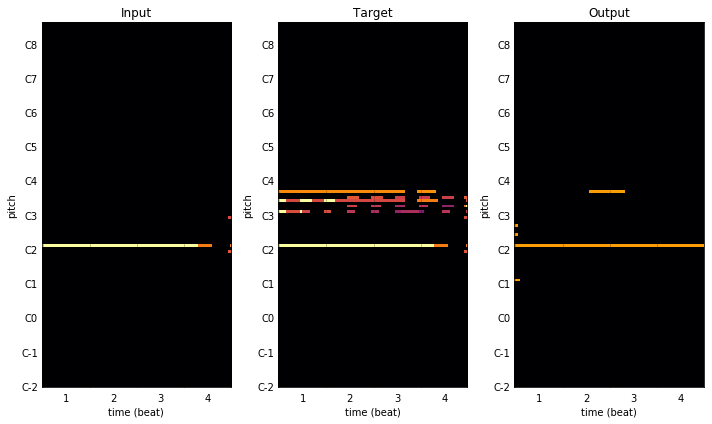

In [14]:
# Inspect a random input-output sample
sample_index = np.random.randint(len(input_test))
sample_input = input_test[sample_index] * 127
sample_full = full_test[sample_index] * 127
sample_output = decoded_test[sample_index] * 127

# Set all velocity values < threshold to zero
threshold = 10
sample_output[sample_output < threshold] = 0
sample_output[sample_output >= threshold] = 100

print(sample_input.shape)
print(sample_full.shape)
print(sample_output.shape)

# Plot comparison
fig, ax = plt.subplots(1,3)
fig.set_size_inches(10, 6, forward=True)
ax[0].set_title('Input')
ax[1].set_title('Target')
ax[2].set_title('Output')
pypianoroll.plot_pianoroll(ax[0], sample_input, beat_resolution=24, cmap='inferno')
pypianoroll.plot_pianoroll(ax[1], sample_full, beat_resolution=24, cmap='inferno')
pypianoroll.plot_pianoroll(ax[2], sample_output, beat_resolution=24, cmap='inferno')
fig.tight_layout()

# Play comparison
pianoroll_utils.playPianoroll(sample_input)
# pianoroll_utils.playPianoroll(sample_full)
# pianoroll_utils.playPianoroll(sample_output)
pianoroll_utils.playPianoroll_events(sample_output.swapaxes(0,1))



## Sequence-to-sequence model

In [ ]:
'''Sequence to sequence example in Keras (character-level).
This script demonstrates how to implement a basic character-level
sequence-to-sequence model. We apply it to translating
short English sentences into short French sentences,
character-by-character. Note that it is fairly unusual to
do character-level machine translation, as word-level
models are more common in this domain.
# Summary of the algorithm
- We start with input sequences from a domain (e.g. English sentences)
    and correspding target sequences from another domain
    (e.g. French sentences).
- An encoder LSTM turns input sequences to 2 state vectors
    (we keep the last LSTM state and discard the outputs).
- A decoder LSTM is trained to turn the target sequences into
    the same sequence but offset by one timestep in the future,
    a training process called "teacher forcing" in this context.
    Is uses as initial state the state vectors from the encoder.
    Effectively, the decoder learns to generate `targets[t+1...]`
    given `targets[...t]`, conditioned on the input sequence.
- In inference mode, when we want to decode unknown input sequences, we:
    - Encode the input sequence into state vectors
    - Start with a target sequence of size 1
        (just the start-of-sequence character)
    - Feed the state vectors and 1-char target sequence
        to the decoder to produce predictions for the next character
    - Sample the next character using these predictions
        (we simply use argmax).
    - Append the sampled character to the target sequence
    - Repeat until we generate the end-of-sequence character or we
        hit the character limit.
# Data download
English to French sentence pairs.
http://www.manythings.org/anki/fra-eng.zip
Lots of neat sentence pairs datasets can be found at:
http://www.manythings.org/anki/
# References
- Sequence to Sequence Learning with Neural Networks
    https://arxiv.org/abs/1409.3215
- Learning Phrase Representations using
    RNN Encoder-Decoder for Statistical Machine Translation
    https://arxiv.org/abs/1406.1078
'''
from __future__ import print_function

from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np

batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = 'fra-eng/fra.txt'

# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.







# START HERE

# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, NUM_PITCHES))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, NUM_PITCHES))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='relu')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)
# Save model
model.save('s2s.h5')

# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence


for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

# Unit predictors

## README

The broad objective is to learn a sequence predictor which, given a arbitrary sequence of units (of arbitrary length, in the form of embedding vectors), predicts a new unit (in equivalent vector form). 

One key consideration is what **input length** to consider. We could use a fixed input length (sliding window), or a variable input length - which is ideal because we want to be able to predict when the song first starts, up to the end of the song. Fixed input lengths can still work for these cases (by padding and truncating), but this may have detrimental effects on the results.

Beyond that, we also need to consider several approaches to the problem:

### Regression - using VAEs

The prediction will be a latent vector. For this latent vector to be decoded back into an acceptable musical unit, we use a variational autoencoder which has trained a latent space (as corresponding encoder/decoder) of musical units.

### Classification - using word embeddings

Alternatively, we can build a vocabulary of units and learn word embeddings of these units, then use standard NLP-type word prediction methods to choose the best new unit from our vocabulary. This shares a similar strength to unit-selection methods, in that our vocabulary will consist of "musicality-guaranteed" units.

#### Resources
- Multiple input RNN [video](https://www.youtube.com/watch?v=FlVJo7LbOzY)
- Useful [Stack Overflow post](https://datascience.stackexchange.com/questions/26366/training-an-rnn-with-examples-of-different-lengths-in-keras) on variable input lengths

## Regression

### RegressionLSTM V1

#### Overview

First attempt at creating a unit-predictor. 

Sources:
- Keras [docs](https://keras.io/preprocessing/sequence/#timeseriesgenerator) for TimeSeriesGenerator
- [StackOverflow](https://stackoverflow.com/questions/49555701/timeseriesgenerator-for-two-or-more-inputs) question on multiple input timeseriesgenerator

#### Notes

The output is not any good; it seems to favor consistent and non-commital predictions, simply banging out some middle-octave chord at the start and continuing the same kind of unit throughout.

On the bright side, it knows when to keep quiet - it predicts true positive silences pretty well haha.

One important thing to consider is that the loss/accuracy are not improving. Why? One thing to think about: **Shouldn't we be able to at least overfit the training data?** I thought it should always be possible to overfit training data, and that it's only generalization to test set which would be difficult here.

PS. We don't even have a validation set yet. Welp.

#### Next steps
Hard to say exactly. But some thoughts:
1. Simplify: word2vec, and predict directly on single ticks instead of 96-tick units.
2. Building the embeddings by itself may not be as useful as training the embeddings simultaneously with the prediction model. Training both models in conjunction with each other might be the best way to go.
3. Find out if it's possible to get better results by forcing the model to overfit the training data. I thought this should be possible.
4. We might be able to make this prediction task easier if we reduce the latent dimension (intuitively, a smaller latent dimension means fewer ways to get it wrong).
5. ~~Try a (much) larger window length?~~ Tried with WINDOW_LENGTH=39. It seems to help add confidence (velocity) to the output, but only barely. Not much difference in way of loss/accuracy, and anyways it should be possible to make predictions based on a small number of units (and even instantaneously based on the current input).
6. To increase reliance on input (rather than comp), add a dropout layer to the comp LSTM.

#### Model training

In [146]:
WINDOW_LENGTH = 3

In [147]:
latent_dim = 1600
epsilon_std = 1.0
# We need to have our encoder and decoder ready
MODEL_FILE = './models/vae_v3_encoder.h5'
encoder = load_model(MODEL_FILE, 
                         custom_objects={'latent_dim': latent_dim, 'epsilon_std': epsilon_std})
MODEL_FILE = './models/vae_v3_generator.h5'
decoder = load_model(MODEL_FILE, 
                         custom_objects={'latent_dim': latent_dim, 'epsilon_std': epsilon_std})

In [148]:
# Create a data generator
def get_multiple_generator(data1, data2, targets, window_length = 5, batch_size = 32):
    data1_gen = TimeseriesGenerator(data1, targets,
                               length=window_length, sampling_rate=1,
                               batch_size=batch_size)

    data2_gen = TimeseriesGenerator(data2, targets,
                               length=window_length, sampling_rate=1,
                               batch_size=batch_size)
    while True:
        for x in range(len(data1_gen)):
            x_1, y = data1_gen[x]
            x_2, _ = data2_gen[x]
            yield [x_1, x_2], y

data_gen = get_multiple_generator(seq_embed['input'], seq_embed['comp'], seq_embed['comp'], 
                                  window_length=WINDOW_LENGTH, batch_size=32)

In [149]:
data_dim = latent_dim # Our model predicts embeddings, so our data is the size of the embedding

# First layer
input1 = Input(shape=(WINDOW_LENGTH, data_dim))
input2 = Input(shape=(WINDOW_LENGTH, data_dim))
lstm1 = LSTM(500)(input1)
lstm2 = LSTM(500)(input2)

# Second layer
merged = concatenate([lstm1, lstm2])

# Third layer
hidden = Dense(data_dim, activation='relu')(merged)
output = Dense(data_dim, activation='linear')(hidden)

model = Model(inputs=[input1, input2], outputs=output)
model.compile(loss='mse', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           (None, 3, 1600)      0                                            
__________________________________________________________________________________________________
input_28 (InputLayer)           (None, 3, 1600)      0                                            
__________________________________________________________________________________________________
lstm_27 (LSTM)                  (None, 500)          4202000     input_27[0][0]                   
__________________________________________________________________________________________________
lstm_28 (LSTM)                  (None, 500)          4202000     input_28[0][0]                   
__________________________________________________________________________________________________
concatenat

In [150]:
# and now train the model
# batch_size should be appropriate to your memory size
# number of epochs should be higher for real world problems
model.fit_generator(generator=data_gen,
                    steps_per_epoch=32,
                    epochs=10)

MODEL_FILE = './models/rlstm_v1.h5'
model.save(MODEL_FILE)# creates a HDF5 file
print("Saved Keras model to", MODEL_FILE)

Epoch 1/10
32/32 [==============================] - 5s 146ms/step - loss: 0.0357 - acc: 0.1719
Epoch 2/10
32/32 [==============================] - 1s 37ms/step - loss: 0.0257 - acc: 0.1748
Epoch 3/10
32/32 [==============================] - 1s 37ms/step - loss: 0.0211 - acc: 0.3135
Epoch 4/10
32/32 [==============================] - 1s 38ms/step - loss: 0.0260 - acc: 0.2744
Epoch 5/10
32/32 [==============================] - 1s 38ms/step - loss: 0.0278 - acc: 0.1787
Epoch 6/10
32/32 [==============================] - 1s 37ms/step - loss: 0.0261 - acc: 0.4346
Epoch 7/10
32/32 [==============================] - 1s 37ms/step - loss: 0.0270 - acc: 0.3564
Epoch 8/10
32/32 [==============================] - 1s 37ms/step - loss: 0.0223 - acc: 0.4541
Epoch 9/10
32/32 [==============================] - 1s 37ms/step - loss: 0.0288 - acc: 0.3770
Epoch 10/10
32/32 [==============================] - 1s 37ms/step - loss: 0.0165 - acc: 0.4111
Saved Keras model to ./models/rlstm_v1.h5


### RegressionLSTM V2

#### Overview

Trying the rlstm again, but on a much smaller latent dimension than before (10 instead of 1600).

From the _Next steps_ suggestion in RLSTM V1:

> "4. We might be able to make this prediction task easier if we reduce the latent dimension (intuitively, a smaller latent dimension means fewer ways to get it wrong)."

#### Notes

It feels like the main problem here is a code problem, not an approach/model problem. The loss is still behaving erratically, going up and going down unpredictably. Trying to reduce the learning rate, and trying different optimizers did not seem to help. Current suspicion (based on [this](https://github.com/keras-team/keras/issues/5818)) is that training issues are due to the data generator, which may well be the issue since I don't understand it properly.

Let's move away from the data generator for now, try make a traditional dataset to train on.

#### Next steps
Hard to say exactly. But some thoughts:
1. Simplify: word2vec, and predict directly on single ticks instead of 96-tick units.
2. Building the embeddings by itself may not be as useful as training the embeddings simultaneously with the prediction model. Training both models in conjunction with each other might be the best way to go.
3. Find out if it's possible to get better results by forcing the model to overfit the training data. I thought this should be possible.
4. ~~We might be able to make this prediction task easier if we reduce the latent dimension (intuitively, a smaller latent dimension means fewer ways to get it wrong).~~ Just did this with 10 dimensions, prediction doesn't seem any better than the 1600-dimension one.
5. ~~Try a (much) larger window length?~~ Tried with WINDOW_LENGTH=39. It seems to help add confidence (velocity) to the output, but only barely. Not much difference in way of loss/accuracy, and anyways it should be possible to make predictions based on a small number of units (and even instantaneously based on the current input).
6. ~~To increase reliance on input (rather than comp), add a dropout layer to the comp LSTM.~~ Tried this using variations of dropout and recurrent_dropout as LSTM parameters, but didn't have much effect. Probably need to solve some underlying problem first before applying dropout.
7. Troubleshoot / don't use data generator, which may be causing all these problems.

#### Model training

In [6]:
latent_dim = 10
epsilon_std = 1.0
# We need to have our encoder and decoder ready
MODEL_FILE = './models/vae_v4_encoder.h5'
encoder = load_model(MODEL_FILE, 
                         custom_objects={'latent_dim': latent_dim, 'epsilon_std': epsilon_std})
MODEL_FILE = './models/vae_v4_generator.h5'
decoder = load_model(MODEL_FILE, 
                         custom_objects={'latent_dim': latent_dim, 'epsilon_std': epsilon_std})

In [103]:
WINDOW_LENGTH = 3

# Create a data generator
def get_multiple_generator(data1, data2, targets, window_length = 5, batch_size = 128):
    data1_gen = TimeseriesGenerator(data1, targets,
                               length=window_length, sampling_rate=1,
                               batch_size=batch_size)

    data2_gen = TimeseriesGenerator(data2, targets,
                               length=window_length, sampling_rate=1,
                               batch_size=batch_size)
    while True:
        for x in range(len(data1_gen)):
            x_1, y = data1_gen[x]
            x_2, _ = data2_gen[x]
            yield [x_1, x_2], y

data_gen = get_multiple_generator(seq_embed['input'], seq_embed['comp'], seq_embed['comp'], 
                                  window_length=WINDOW_LENGTH, batch_size=128)

In [104]:
data_dim = latent_dim # Our model predicts embeddings, so our data is the size of the embedding

# First layer
input1 = Input(shape=(WINDOW_LENGTH, data_dim))
input2 = Input(shape=(WINDOW_LENGTH, data_dim))
lstm1 = LSTM(200)(input1)
lstm2 = LSTM(200)(input2)

# Second layer
merged = concatenate([lstm1, lstm2])

# Third layer
hidden = Dense(1000, activation='relu')(merged)
dropped = Dropout(0.2)(hidden)
output = Dense(data_dim, activation='linear')(dropped)

model = Model(inputs=[input1, input2], outputs=output)
sgd = optimizers.SGD(lr=0.001)
model.compile(loss='mse', optimizer=sgd, metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_35 (InputLayer)           (None, 3, 10)        0                                            
__________________________________________________________________________________________________
input_36 (InputLayer)           (None, 3, 10)        0                                            
__________________________________________________________________________________________________
lstm_35 (LSTM)                  (None, 200)          168800      input_35[0][0]                   
__________________________________________________________________________________________________
lstm_36 (LSTM)                  (None, 200)          168800      input_36[0][0]                   
__________________________________________________________________________________________________
concatenat

In [105]:
# and now train the model
# batch_size should be appropriate to your memory size
# number of epochs should be higher for real world problems
model.fit_generator(generator=data_gen,
                    steps_per_epoch=128,
                    epochs=50)

MODEL_FILE = './models/rlstm_v2.h5'
model.save(MODEL_FILE)# creates a HDF5 file
print("Saved Keras model to", MODEL_FILE)

Epoch 1/50


TypeError: tuple object is not an iterator

### RegressionLSTM V3

#### Overview

From previous attempt:

> Current suspicion (based on [this](https://github.com/keras-team/keras/issues/5818)) is that training issues are due to the data generator, which may well be the issue since I don't understand it properly.

And so in this model, we simply try again but instead of using a data generator, we create the standard dataset setup.

#### Notes

All experiments in this version use a latent dimension of 10, corresponding to vae_v4.

Changing the data generator worked! The loss progression now makes sense, the predictor is actually making some decent predictions!

#### Attempt 1
```
Window length = 3
Recurrent node = LSTM
Recurrent dim = 200
Hidden dim = 1000
After 10 epochs, loss: 0.2585 - val_loss: 0.3402
```

Let's change from window length of 3 to 4, since songs tend to repeat after 4 measures.

#### Attempt 2
```
Window length = 4
After 10 epochs, loss: 0.2565 - val_loss: 0.3066
```

No huge difference in loss, but validation is better. Let's play with some of the other parameters. 

#### Attempt 3
```
Window length = 4
Recurrent node: LSTM
Recurrent dim = 800
Hidden dim = 1000
After 10 epochs, loss: 0.1736 - val_loss: 0.2841
```
Both training and validation loss are much better after amping up the number of neurons! But validation is a lot worse. Might need to apply some regularization.

#### Attempt 4
```
Window length = 4
Recurrent node: LSTM
Recurrent dim = 800
Hidden dim = 1000
Dropout = 0.2 after hidden dense layer
Dropout = 0.1 in input LSTM
Dropout = 0.7 in comp LSTM
After 50 epochs, loss: 0.1399 - val_loss: 0.2778
```
Overall, the main problem with the prediction now is that it depends too strongly on the previous comp window. And so, the new predictions get weaker and weaker and eventually die off after roughly one WINDOW_LENGTH of predictions. We need to force the model to learn to predict based on the input (more than the previous comp).

To do this, we focused on increasing dropout on the comp input LSTM. This seems to help! Crucially, **it appears that validation (as well as training) loss is not as good as the version without dropout, but in reality when we are predicting on top of old predictions, the dropout is so much better because it forces the model to rely on the input instead of the previous comp**. There might be a need here to reframe the training data so that the model takes into account the fact that it will be predicting based on its own imperfect input. **Perhaps add noise to the data to model an imperfect prediction being fed into the next input**?

For now, the predicted comp tends to be quite repetitive and plain, barely even noticeable.

And quite importantly, the problem of playing back blurred pianorolls is quite a big issue now. Taking the mean velocity of a contiguous non-zero pitch is not enough anymore because quite often multiple repeated notes across several measures tend to blur into one long note with a single onset.

#### Next steps
1. Try adding noise to the input data so that we model making predictions based on imperfect previous comp predictions.
2. How to fix the problem of blurred pianorolls? Either fix the playback function, or fix the autoencoder. Or both.

#### Model training

In [6]:
latent_dim = 10
epsilon_std = 1.0
# We need to have our encoder and decoder ready
MODEL_FILE = './models/vae_v4_encoder.h5'
encoder = load_model(MODEL_FILE, 
                         custom_objects={'latent_dim': latent_dim, 'epsilon_std': epsilon_std})
MODEL_FILE = './models/vae_v4_generator.h5'
decoder = load_model(MODEL_FILE, 
                         custom_objects={'latent_dim': latent_dim, 'epsilon_std': epsilon_std})

In [135]:
data_dim = latent_dim # Our model predicts embeddings, so our data is the size of the embedding
recurrent_dim = 800
dense_hidden_dim = 1000

# First layer
input1 = Input(shape=(WINDOW_LENGTH, data_dim))
input2 = Input(shape=(WINDOW_LENGTH, data_dim))
lstm1 = LSTM(recurrent_dim, dropout=0.1)(input1)
lstm2 = LSTM(recurrent_dim, dropout=0.7)(input2)

# Second layer
merged = concatenate([lstm1, lstm2])

# Third layer
hidden = Dense(dense_hidden_dim, activation='relu')(merged)
dropped = Dropout(0.2)(hidden)
output = Dense(data_dim, activation='linear')(dropped)

model = Model(inputs=[input1, input2], outputs=output)
model.compile(loss='mse', optimizer='rmsprop') #, metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_51 (InputLayer)           (None, 4, 10)        0                                            
__________________________________________________________________________________________________
input_52 (InputLayer)           (None, 4, 10)        0                                            
__________________________________________________________________________________________________
lstm_47 (LSTM)                  (None, 800)          2595200     input_51[0][0]                   
__________________________________________________________________________________________________
lstm_48 (LSTM)                  (None, 800)          2595200     input_52[0][0]                   
__________________________________________________________________________________________________
concatenat

In [136]:
# and now train the model
# batch_size should be appropriate to your memory size
# number of epochs should be higher for real world problems
model.fit([x_input_train, x_comp_train], y_comp_train,
          epochs=50,
          batch_size=128,
          shuffle=True,
          validation_data=([x_input_test, x_comp_test], y_comp_test))

MODEL_FILE = './models/rlstm_v3.h5'
model.save(MODEL_FILE)# creates a HDF5 file
print("Saved Keras model to", MODEL_FILE)

Train on 40044 samples, validate on 2082 samples
Epoch 1/50
40044/40044 [==============================] - 18s 441us/step - loss: 0.5800 - val_loss: 0.4897
Epoch 2/50
40044/40044 [==============================] - 12s 305us/step - loss: 0.5133 - val_loss: 0.4567
Epoch 3/50
40044/40044 [==============================] - 12s 307us/step - loss: 0.4841 - val_loss: 0.4309
Epoch 4/50
40044/40044 [==============================] - 12s 306us/step - loss: 0.4590 - val_loss: 0.4110
Epoch 5/50
40044/40044 [==============================] - 12s 307us/step - loss: 0.4363 - val_loss: 0.3932
Epoch 6/50
40044/40044 [==============================] - 12s 305us/step - loss: 0.4166 - val_loss: 0.3836
Epoch 7/50
40044/40044 [==============================] - 12s 304us/step - loss: 0.3972 - val_loss: 0.3681
Epoch 8/50
40044/40044 [==============================] - 12s 306us/step - loss: 0.3800 - val_loss: 0.3500
Epoch 9/50
40044/40044 [==============================] - 12s 306us/step - loss: 0.3630 - val_l

### RegressionLSTM V4

#### Overview

Carried forward from previous model, with some new tests:
- Uses VAE_V5, latent dimension of 500 and pianorolls with NUM_PITCHES = 96
- Add noise to the training comp embeddings, to model imperfect predictions

#### Notes

All experiments in this version use a latent dimension of 500, corresponding to vae_v5.

#### Attempt 1
```
Window length = 4
Recurrent node: LSTM
Recurrent dim = 800
Hidden dim = 1000
Dropout = 0.2 after hidden dense layer
Dropout = 0.1 in input LSTM
Dropout = 0.7 in comp LSTM
After 50 epochs, 
```
Loss from previous model was `loss: 0.1399 - val_loss: 0.2778`, but apparently that's not comparable, I'm guessing because the latent dimension size has changed? But why would the dimension affect the _mean_ squared error?

But frankly, the predicted output looks pretty _perfect_. This is almost certainly a case of overfitting, unfortunately. We need to prepare a test set of sequence data to properly visualize against (we cannot use the same test data we used to get the validation error because those are not in sequence).

#### Update

Yes, after testing on a completely separate test dataset, I can indeed confirm that the model was just totally overfitting, and the predictions on the test dataset are mostly ghost notes. But now we have a proper target to aim for. Onwards!

#### Next steps
1. 

#### Model training

In [7]:
latent_dim = 500
epsilon_std = 1.0
# We need to have our encoder and decoder ready
MODEL_FILE = './models/vae_v5_encoder_denoise.h5'
encoder = load_model(MODEL_FILE, 
                         custom_objects={'latent_dim': latent_dim, 'epsilon_std': epsilon_std})
MODEL_FILE = './models/vae_v5_generator_denoise.h5'
decoder = load_model(MODEL_FILE, 
                         custom_objects={'latent_dim': latent_dim, 'epsilon_std': epsilon_std})

In [8]:
data_dim = latent_dim # Our model predicts embeddings, so our data is the size of the embedding
recurrent_dim = 800
dense_hidden_dim = 1000

# First layer
input1 = Input(shape=(WINDOW_LENGTH, data_dim))
input2 = Input(shape=(WINDOW_LENGTH, data_dim))
lstm1 = LSTM(recurrent_dim, dropout=0.1)(input1)
lstm2 = LSTM(recurrent_dim, dropout=0.7)(input2)

# Second layer
merged = concatenate([lstm1, lstm2])

# Third layer
hidden = Dense(dense_hidden_dim, activation='relu')(merged)
dropped = Dropout(0.2)(hidden)
output = Dense(data_dim, activation='linear')(dropped)

model = Model(inputs=[input1, input2], outputs=output)
model.compile(loss='mse', optimizer='rmsprop') #, metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 4, 500)       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 4, 500)       0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 800)          4163200     input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 800)          4163200     input_2[0][0]                    
__________________________________________________________________________________________________
concatenat

In [38]:
# and now train the model
# batch_size should be appropriate to your memory size
# number of epochs should be higher for real world problems
model.fit([x_input_train, x_comp_train], y_comp_train,
          epochs=50,
          batch_size=128,
          shuffle=True,
          validation_data=([x_input_test, x_comp_test], y_comp_test))

MODEL_FILE = './models/rlstm_v4.h5'
model.save(MODEL_FILE)# creates a HDF5 file
print("Saved Keras model to", MODEL_FILE)

Train on 34991 samples, validate on 1817 samples
Epoch 1/50
34991/34991 [==============================] - 14s 399us/step - loss: 0.0348 - val_loss: 0.0309
Epoch 2/50
34991/34991 [==============================] - 14s 394us/step - loss: 0.0275 - val_loss: 0.0289
Epoch 3/50
34991/34991 [==============================] - 14s 394us/step - loss: 0.0237 - val_loss: 0.0279
Epoch 4/50
34991/34991 [==============================] - 14s 398us/step - loss: 0.0213 - val_loss: 0.0273
Epoch 5/50
34991/34991 [==============================] - 14s 397us/step - loss: 0.0195 - val_loss: 0.0269
Epoch 6/50
34991/34991 [==============================] - 14s 394us/step - loss: 0.0182 - val_loss: 0.0266
Epoch 7/50
34991/34991 [==============================] - 14s 395us/step - loss: 0.0171 - val_loss: 0.0264
Epoch 8/50
34991/34991 [==============================] - 14s 394us/step - loss: 0.0163 - val_loss: 0.0265
Epoch 9/50
34991/34991 [==============================] - 14s 394us/step - loss: 0.0156 - val_l

### RegressionLSTM V5

#### Overview

Building on top of V4 model, but with crucial new changes:
- Uses VAE_V7 (latent dimension of 500 and pianorolls with NUM_PITCHES = 96)
- Trying something new: using `fit_generator` to generate windowed data on the fly for data efficiency

#### Notes

All experiments in this version use a latent dimension of 500, corresponding to vae_v7.

#### Attempt 1
```
Num pianorolls: 1000
input.shape == comp.shape: (23086, 500)
Time: ~7 minutes per epoch
Time per step: 453s 264ms/step
Best error: loss: 0.0235 - val_loss: 0.0317
```
Validation loss is quite disappointing, it scarcely improves at all from epoch 1 to epoch 50. Training loss goes down nicely, and we can confirm that testing on training data we get pretty perfect results, but on test data it is mostly ghost output (but very slightly better than the previous model?).

#### Attempt 1.b

Use Attempt 1's model to predict accompaniments with a unit-selection scheme. Unforunately, output is very poor. Selected units don't seem to be in the same key as the input. On the bright side, at least it does something.

#### Next steps
1. Try using the predicted output with unit selection!

#### Model training

In [4]:
latent_dim = 500
epsilon_std = 1.0
# We need to have our encoder and decoder ready
MODEL_FILE = './models/vae_v7_encoder.h5'
encoder = load_model(MODEL_FILE, 
                         custom_objects={'latent_dim': latent_dim, 'epsilon_std': epsilon_std})
MODEL_FILE = './models/vae_v7_decoder.h5'
decoder = load_model(MODEL_FILE, 
                         custom_objects={'latent_dim': latent_dim, 'epsilon_std': epsilon_std})

In [5]:
data_dim = latent_dim # Our model predicts embeddings, so our data is the size of the embedding
recurrent_dim = 800
dense_hidden_dim = 1000

# First layer
input1 = Input(shape=(WINDOW_LENGTH, data_dim))
input2 = Input(shape=(WINDOW_LENGTH, data_dim))
lstm1 = LSTM(recurrent_dim, dropout=0.1)(input1)
lstm2 = LSTM(recurrent_dim, dropout=0.7)(input2)

# Second layer
merged = concatenate([lstm1, lstm2])

# Third layer
hidden = Dense(dense_hidden_dim, activation='relu')(merged)
dropped = Dropout(0.2)(hidden)
output = Dense(data_dim, activation='linear')(dropped)

model = Model(inputs=[input1, input2], outputs=output)
model.compile(loss='mse', optimizer='rmsprop') #, metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 4, 500)       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 4, 500)       0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 800)          4163200     input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 800)          4163200     input_2[0][0]                    
__________________________________________________________________________________________________
concatenat

In [6]:
# and now train the model
# batch_size should be appropriate to your memory size
# number of epochs should be higher for real world problems

batch_size=128
model.fit_generator(generator=data_gen_train,
                    steps_per_epoch=len(data_gen_train),#/batch_size,
                    epochs=10,
                    validation_data=data_gen_test)

MODEL_FILE = './models/rlstm_v5.h5'
model.save(MODEL_FILE)# creates a HDF5 file
print("Saved Keras model to", MODEL_FILE)

Epoch 1/10
1716/1716 [==============================] - 461s 269ms/step - loss: 0.0342 - val_loss: 0.0305
Epoch 2/10
1716/1716 [==============================] - 459s 267ms/step - loss: 0.0312 - val_loss: 0.0300
Epoch 3/10
1716/1716 [==============================] - 455s 265ms/step - loss: 0.0302 - val_loss: 0.0299
Epoch 4/10
1716/1716 [==============================] - 455s 265ms/step - loss: 0.0294 - val_loss: 0.0301
Epoch 5/10
1716/1716 [==============================] - 456s 266ms/step - loss: 0.0285 - val_loss: 0.0303
Epoch 6/10
1716/1716 [==============================] - 455s 265ms/step - loss: 0.0276 - val_loss: 0.0304
Epoch 7/10
1716/1716 [==============================] - 451s 263ms/step - loss: 0.0266 - val_loss: 0.0305
Epoch 8/10
1716/1716 [==============================] - 455s 265ms/step - loss: 0.0255 - val_loss: 0.0309
Epoch 9/10
1716/1716 [==============================] - 454s 265ms/step - loss: 0.0245 - val_loss: 0.0313
Epoch 10/10
1716/1716 [=======================

### RegressionLSTM V6

#### Overview

Onsets-only variation of V5 model:
- Uses VAE_V9 (latent dimension of 50 and pianorolls with NUM_PITCHES = 96)
- MUUCH smaller network since latent dimension is also much smaller (dropped from 10,427,900 to )
- Add Gaussian Noise to input_2

#### Attempt 1
```
Num pianorolls: 1000
input.shape == comp.shape: (52540, 50)

GaussianNoise@input_2: 0.2

After 10 epochs,
loss: 0.4549 - val_loss: 0.5434

Saved Keras model to ./models/rlstm_v6.h5
CPU times: user 1h 15min 56s, sys: 42min 14s, total: 1h 58min 10s
Wall time: 1h 35min 30s
```
Like in previous models, validation loss scarcely improves at all from epoch 1 to epoch 10. Training loss goes down slowly.

#### Next steps
1. Try using the predicted output with unit selection!

#### Model training

In [4]:
latent_dim = 50
epsilon_std = 1.0
# We need to have our encoder and decoder ready
MODEL_FILE = './models/vae_v9_encoder_latent50.h5'
encoder = load_model(MODEL_FILE, 
                         custom_objects={'latent_dim': latent_dim, 'epsilon_std': epsilon_std})
MODEL_FILE = './models/vae_v9_decoder_latent50.h5'
decoder = load_model(MODEL_FILE, 
                         custom_objects={'latent_dim': latent_dim, 'epsilon_std': epsilon_std})

In [12]:
WINDOW_LENGTH = 4
data_dim = latent_dim # Our model predicts embeddings, so our data is the size of the embedding
recurrent_dim = 200
dense_hidden_dim = 500

# First layer
input1 = Input(shape=(WINDOW_LENGTH, data_dim))
input2 = Input(shape=(WINDOW_LENGTH, data_dim))
input2_noisy = GaussianNoise(0.2)(input2)
lstm1 = LSTM(recurrent_dim)(input1)
lstm2 = LSTM(recurrent_dim)(input2_noisy)

# Second layer
merged = concatenate([lstm1, lstm2])

# Third layer
hidden = Dense(dense_hidden_dim, activation='relu')(merged)
output = Dense(data_dim, activation='linear')(hidden)

model = Model(inputs=[input1, input2], outputs=output)
model.compile(loss='mse', optimizer='adam') #, metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 4, 50)        0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            (None, 4, 50)        0                                            
__________________________________________________________________________________________________
gaussian_noise_4 (GaussianNoise (None, 4, 50)        0           input_10[0][0]                   
__________________________________________________________________________________________________
lstm_7 (LSTM)                   (None, 200)          200800      input_9[0][0]                    
__________________________________________________________________________________________________
lstm_8 (LS

In [13]:
%%time
# and now train the model
# batch_size should be appropriate to your memory size
# number of epochs should be higher for real world problems

batch_size=128
model.fit_generator(generator=data_gen_train,
                    steps_per_epoch=len(data_gen_train),#/batch_size,
                    epochs=10,
                    validation_data=data_gen_test)

MODEL_FILE = './models/rlstm_v6.h5'
model.save(MODEL_FILE)# creates a HDF5 file
print("Saved Keras model to", MODEL_FILE)

Epoch 1/10
3451/3451 [==============================] - 563s 163ms/step - loss: 0.5571 - val_loss: 0.5323
Epoch 2/10
3451/3451 [==============================] - 569s 165ms/step - loss: 0.5254 - val_loss: 0.5345
Epoch 3/10
3451/3451 [==============================] - 568s 165ms/step - loss: 0.5090 - val_loss: 0.5301
Epoch 4/10
3451/3451 [==============================] - 560s 162ms/step - loss: 0.4975 - val_loss: 0.5325
Epoch 5/10
3451/3451 [==============================] - 560s 162ms/step - loss: 0.4884 - val_loss: 0.5318
Epoch 6/10
3451/3451 [==============================] - 582s 169ms/step - loss: 0.4801 - val_loss: 0.5343
Epoch 7/10
3451/3451 [==============================] - 583s 169ms/step - loss: 0.4726 - val_loss: 0.5377
Epoch 8/10
3451/3451 [==============================] - 586s 170ms/step - loss: 0.4666 - val_loss: 0.5393
Epoch 9/10
3451/3451 [==============================] - 585s 170ms/step - loss: 0.4612 - val_loss: 0.5398
Epoch 10/10
3451/3451 [=======================

In [8]:
MODEL_FILE = './models/rlstm_v6.h5'
model = load_model(MODEL_FILE)

### Prediction and results

Use the models trained above to predict an accompanying sequence.

#### DEPRECATED
The dataset used in this section are completely separated from the model training processes above. 

Model training had their own training/validation dataset, but here we actually have a previously unseen dataset `seq_units['input_test']` and `seq_units['comp_test']` and their corresponding embeddings dataset for prediction. 

The reason we cannot use the train/validation set here is because the order beyond a fixed window size is not respected in the train/validation dataset. This test set retains the full order of many songs together.

In [5]:
from sklearn.neighbors import NearestNeighbors
import sklearn.externals

# Load up the embeddings prediction model
MODEL_FILE = './models/rlstm_v5.h5'
model = load_model(MODEL_FILE)

# Load up the KNN model
KNN_MODEL_FILENAME = "./models/vae_v7_unit_selector_knn.pkl"
knn_model, UNITS_FILE = sklearn.externals.joblib.load(KNN_MODEL_FILENAME)
# Load KNN units
units_f = h5py.File(UNITS_FILE, 'r')
knn_units = units_f['units_train']
print("knn_units:", knn_units.shape)

knn_units: (220409, 96, 96, 1)


In [31]:
# If not using HDF5
seq_units_input = seq_units['input_train']
seq_units_comp = seq_units['comp_train']
seq_embed_input = seq_embed['input_train']
seq_embed_comp = seq_embed['comp_train']

In [12]:
NUM_PREDICTIONS = 8
num_units = WINDOW_LENGTH + NUM_PREDICTIONS
# Grab a random sequence of embeddings as input
unit_index = np.random.randint(seq_embed_comp.shape[0] - num_units)

# Take the full WINDOW_LENGTH + 1 embeddings for reference
decoded_comp_embed = seq_embed_comp[unit_index:unit_index + num_units]

# Predict NUM_PREDICTIONS embeddings
predicted_comp_embed = seq_embed_input[unit_index:unit_index + WINDOW_LENGTH].copy() #seq_embed_comp[unit_index:unit_index + WINDOW_LENGTH].copy()
# knn_comp = np.zeros((WINDOW_LENGTH, NUM_PITCHES, NUM_TICKS)) #seq_units_comp[unit_index:unit_index + WINDOW_LENGTH].copy().squeeze()
for i, _ in enumerate(range(NUM_PREDICTIONS)):
    input1 = np.array([
        seq_embed_input[unit_index + i : unit_index + WINDOW_LENGTH + i]
    ])
    input2 = np.array([
        predicted_comp_embed[-WINDOW_LENGTH:] # The WINDOW_LENGTH latest units
    ])
    # Predict new embedding
    y_comp_embed = model.predict([input1,input2])
    # Append predicted embedding
    predicted_comp_embed = np.concatenate([predicted_comp_embed, y_comp_embed], axis=0)
    
    # Get nearest neighbor
#     knn_index = knn_model.kneighbors(y_comp_embed, return_distance = False)[0][0]
#     sample_knn = knn_units[knn_index].squeeze()[np.newaxis, ...]
#     knn_comp = np.concatenate([knn_comp, sample_knn], axis=0)

# knn_comp = np.concatenate(knn_comp, axis=1)
print(predicted_comp_embed.shape)
# print(knn_comp.shape)

0.011178691864
CPU times: user 15.6 s, sys: 3.22 s, total: 18.8 s
Wall time: 11.2 s


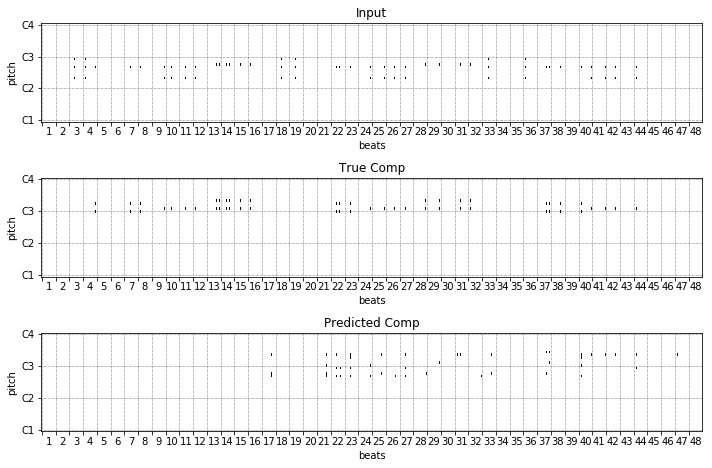

In [155]:
reload(pianoroll_utils)
# Decode the embeddings
predicted_comp_probs = np.concatenate(decoder.predict(predicted_comp_embed), axis=1).squeeze()
# predicted_comp = np.clip(predicted_comp * 0.2, 0, 1)
predicted_comp = pianoroll_utils.pianoroll_preprocess(predicted_comp_probs, MIN_PITCH, MAX_PITCH, is_onsets_matrix=True)
predicted_comp[:43] = 0
predicted_comp[:,:16*24] = 0
# Original embeddings for reference
decoded_comp = np.concatenate(decoder.predict(decoded_comp_embed), axis=1).squeeze()
# Also grab the original units for comparison
model_comp = np.concatenate(seq_units_comp[unit_index:unit_index + num_units], axis=1).squeeze()
model_input = np.concatenate(seq_units_input[unit_index:unit_index + num_units], axis=1).squeeze()

# Plot comparison
fig, ax = plt.subplots(3,1)
fig.set_size_inches(10, 3*2.2, forward=True)
ax[0].set_title('Input')
ax[1].set_title('True Comp')
# ax[2].set_title('Decoded Comp')
ax[2].set_title('Predicted Comp')
# ax[4].set_title('KNN Comp')

min_pitch = 36
max_pitch = 72
model_input_zoom = pianoroll_utils.crop_pianoroll(pianoroll_utils.pad_pianoroll(model_input, MIN_PITCH, MAX_PITCH), min_pitch, max_pitch)
model_comp_zoom = pianoroll_utils.crop_pianoroll(pianoroll_utils.pad_pianoroll(model_comp, MIN_PITCH, MAX_PITCH), min_pitch, max_pitch)
predicted_comp_zoom = pianoroll_utils.crop_pianoroll(pianoroll_utils.pad_pianoroll(predicted_comp, MIN_PITCH, MAX_PITCH), min_pitch, max_pitch)

pianoroll_utils.plot_pianoroll(ax[0], model_input_zoom, min_pitch, max_pitch, cmap='bone_r')
pianoroll_utils.plot_pianoroll(ax[1], model_comp_zoom, min_pitch, max_pitch, cmap='bone_r')
# pianoroll_utils.plot_pianoroll(ax[2], decoded_comp, MIN_PITCH, MAX_PITCH, cmap='bone_r')
pianoroll_utils.plot_pianoroll(ax[2], predicted_comp_zoom, min_pitch, max_pitch, cmap='bone_r')
# pianoroll_utils.plot_pianoroll(ax[4], knn_comp, MIN_PITCH, MAX_PITCH, beat_resolution=24, cmap='Blues')
fig.tight_layout()
plt.savefig('fig/latent_rnn_traindata.eps', format='eps', dpi=1000)

# Listen to the MIDI files
# pianoroll_utils.play_pianoroll(model_input, MIN_PITCH, MAX_PITCH, 'ori', is_onsets_matrix=True, program_number=13)
# # pianoroll_utils.play_pianoroll(model_comp, MIN_PITCH, MAX_PITCH, '0', is_onsets_matrix=True, program_number=13)
# # pianoroll_utils.play_pianoroll(decoded_comp, MIN_PITCH, MAX_PITCH, '1', is_onsets_matrix=True, program_number=13)
# pianoroll_utils.play_pianoroll(predicted_comp, MIN_PITCH, MAX_PITCH, '2', is_onsets_matrix=True, program_number=13)
# # pianoroll_utils.play_pianoroll(knn_comp, MIN_PITCH, MAX_PITCH, '3', is_onsets_matrix=True, program_number=13)
# pianoroll_utils.play_pianoroll( (model_comp + model_input).clip(0,1), MIN_PITCH, MAX_PITCH, '4', is_onsets_matrix=True, program_number=13)
# # pianoroll_utils.play_pianoroll( (decoded_comp + model_input).clip(0,1), MIN_PITCH, MAX_PITCH, '5', is_onsets_matrix=True, program_number=13)
# pianoroll_utils.play_pianoroll( (predicted_comp + model_input).clip(0,1), MIN_PITCH, MAX_PITCH, '6', is_onsets_matrix=True, program_number=13)
# # pianoroll_utils.play_pianoroll( (knn_comp + model_input).clip(0,1), MIN_PITCH, MAX_PITCH, '7', is_onsets_matrix=True, program_number=13)

In [151]:
unit_index = 148868